In [1]:
#hide
!⌈pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/bin/bash: ⌈pip: command not found


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

# From Model to Production

In [3]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [4]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [35]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

In [36]:
im = Image.open(dest)
im.to_thumb(128,128)
1 # Avoid image being pushed to git, comment out the "1" 

1

In [71]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [90]:
!rm -r bears

In [91]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', max_images=10)
        download_images(dest, urls=results)

In [92]:
fns = get_image_files(path)
fns

(#29) [Path('bears/grizzly/001436e1-a552-451b-820c-7272630e80e8.jpg'),Path('bears/grizzly/22705cac-e345-436a-bdca-e1a5f2df24d8.JPG'),Path('bears/grizzly/3d42b1f9-216f-44c2-8b90-32ac1764fdf2.jpg'),Path('bears/grizzly/a4cc5b09-dbfe-46db-8dfd-2e9055094782.jpg'),Path('bears/grizzly/300d42d2-61ce-4800-98d5-658516de349a.jpg'),Path('bears/grizzly/ea4d059b-95a9-48f4-8c18-c7a922d4d482.jpg'),Path('bears/grizzly/266f1618-1aa4-45d8-b17e-7bef8b0209db.jpg'),Path('bears/grizzly/1b14d51d-a965-4543-a81e-8ffc8ed09969.jpg'),Path('bears/grizzly/fe455f04-e4d7-4679-9be4-7c09b6aa1414.jpg'),Path('bears/grizzly/9ec2c143-863a-4c31-a591-475bfe7e78cd.png')...]

In [93]:
failed = verify_images(fns)
failed

(#0) []

In [94]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

# EXPLORATION into...
## Solving “kwargs” issue inside the “ImageBlock” class - help needed

In [95]:
print( type( ImageBlock ) )
print( type( ImageBlock() ) )
print( type( TransformBlock ) )

<class 'function'>
<class 'fastai.data.block.TransformBlock'>
<class 'type'>


In [96]:
tb = ImageBlock()
print( dir(tb) )

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'batch_tfms', 'dl_type', 'dls_kwargs', 'item_tfms', 'type_tfms']


**Lets take a look at stack trace with a really naive RawImage, using a custom helper**

In [97]:
class RawImage():
    def dummy():
        return 1

def RawImageBlock(cls:PILBase=RawImage, **kwargs):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor, dls_kwargs=kwargs)
    
bears = DataBlock(
    blocks=(RawImageBlock(myextraconfig=42), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
type(dls)

AttributeError: type object 'RawImage' has no attribute 'create'

**Now try with everything required supplied by superclass PILImage, and paassing in some additional keyword arguments**

bears.dl_type= <class 'fastai.data.core.TfmdDL'>
bears.dls_kwargs= {'myextraconfig': 42}


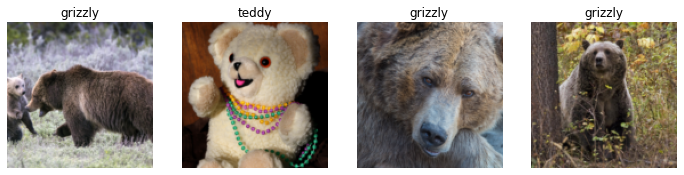

In [103]:
class RawImage(PILImage):
    def dummy():
        return 1

def RawImageBlock(cls:PILBase=RawImage, **kwargs):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor, dls_kwargs=kwargs)
    
bears = DataBlock(
    blocks=(RawImageBlock(myextraconfig=42), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
print('bears.dl_type=', bears.dl_type)
print('bears.dls_kwargs=', bears.dls_kwargs)

**Lets break it to find out where RawImages are created**

In [110]:
class RawImage(PILImage):
    def dummy():
        return 1
    def __init__(self):
        1/0
    @classmethod
    def create(cls, x, **kwargs):
        print('x =', x)
        print('RawImage kwargs =', kwargs, flush=True)
        1/0
                 
def RawImageBlock(cls:PILBase=RawImage, **kwargs):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor, dls_kwargs=kwargs)
    
bears = DataBlock(
    blocks=(RawImageBlock(myextraconfig=42), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
print('bears.dl_type=', bears.dl_type)
print('bears.dls_kwargs=', bears.dls_kwargs)

x = bears/teddy/63bba4f3-4701-4d8b-9d96-e38724b0cc65.jpg
RawImage kwargs = {}


ZeroDivisionError: division by zero

**I'm curious about lines 158 & 159 of the second stack level "block.py:158"**      
about what the contents of **dsets** and **kwargs** look like.     
Also, what does **items** look like on **Line 150** of the third stack level, as its passed to DataSets()  
Lets take a look by subclassing **DataBlock** with instrumenting **dataloaders()** and **datasets()** methods.
https://github.com/fastai/fastai/blob/caf805e3c27c54e723d19cd850b13a76de759e1c/fastai/data/block.py#L142-L165

!!type(items) = <class 'fastcore.foundation.L'>
!!type(items[0]) = <class 'pathlib.PosixPath'>
!!items =  [Path('bears/grizzly/001436e1-a552-451b-820c-7272630e80e8.jpg'), Path('bears/grizzly/22705cac-e345-436a-bdca-e1a5f2df24d8.JPG')]
!type(dsets) =  <class 'fastai.data.core.Datasets'>
!type(dsets.items) =  <class 'list'>
!type(dsets.items[0]) =  <class 'pathlib.PosixPath'>
!dsets[0] =  (RawImage mode=RGB size=702x397, TensorCategory(1))
!dsets[0][0] =  RawImage mode=RGB size=702x397
!kwargs =  {'myextraconfig': 42, 'verbose': False}
!self.dls_kwargs =  {'myextraconfig': 42}
!kwargs =  {'myextraconfig': 42, 'verbose': False}
bears.dl_type= <class 'fastai.data.core.TfmdDL'>
bears.dls_kwargs= {'myextraconfig': 42}


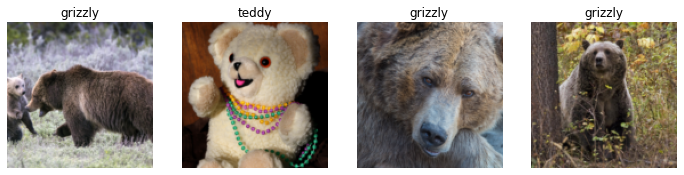

In [165]:
class MyDataBlock(DataBlock):
    def datasets(self,
        source, # The data source
        verbose:bool=False, # Show verbose messages
    ) -> Datasets:
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        print('!!type(items) =', type(items) )
        print('!!type(items[0]) =', type(items[0]) )
        print('!!items = ', items[:2])
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    
    def dataloaders(self,
        source, # The data source
        path:str='.', # Data source and default `Learner` path
        verbose:bool=False, # Show verbose messages
        **kwargs
    ) -> DataLoaders:
        dsets = self.datasets(source, verbose=verbose)
        print('!type(dsets) = ', type(dsets) )        
        print('!type(dsets.items) = ', type(dsets.items) )        
        print('!type(dsets.items[0]) = ', type(dsets.items[0]) )        
        print('!dsets[0] = ', dsets[0])
        print('!dsets[0][0] = ', dsets[0][0])
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        print('!kwargs = ', kwargs)
        print('!self.dls_kwargs = ', self.dls_kwargs)
        print('!kwargs = ', kwargs)
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)    

class RawImage(PILImage):
    def dummy():
        return 1
#    def __init__(self):
#        1/0
#    @classmethod
#    def create(cls, secondsomething, **kwargs):
#        print('RawImage kwargs=', kwargs, flush=True)
#        1/0
                 
def RawImageBlock(cls:PILBase=RawImage, **kwargs):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor, dls_kwargs=kwargs)
    
bears = MyDataBlock(
    blocks=(RawImageBlock(myextraconfig=42), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
print('bears.dl_type=', bears.dl_type)
print('bears.dls_kwargs=', bears.dls_kwargs)

Now break it with 1/0 again

In [164]:
class MyDataBlock(DataBlock):
    def datasets(self,
        source, # The data source
        verbose:bool=False, # Show verbose messages
    ) -> Datasets:
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        print('!!type(items) =', type(items) )
        print('!!type(items[0]) =', type(items[0]) )
        print('!!items = ', items[:2])
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    
    def dataloaders(self,
        source, # The data source
        path:str='.', # Data source and default `Learner` path
        verbose:bool=False, # Show verbose messages
        **kwargs
    ) -> DataLoaders:
        dsets = self.datasets(source, verbose=verbose)
        print('!type(dsets) = ', type(dsets) )        
        print('!type(dsets.items) = ', type(dsets.items) )        
        print('!type(dsets.items[0]) = ', type(dsets.items[0]) )        
        print('!dsets[0] = ', dsets[0])
        print('!dsets[0][0] = ', dsets[0][0])
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        print('!kwargs = ', kwargs)
        print('!self.dls_kwargs = ', self.dls_kwargs)
        print('!kwargs = ', kwargs)
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)    

class RawImage(PILImage):
    def dummy():
        return 1
#    def __init__(self):
#        1/0
    @classmethod
    def create(cls, fn, **kwargs):
        print('RawImage kwargs =', kwargs, flush=True)
        print('Filename =', fn, flush=True)
        1/0
                 
def RawImageBlock(cls:PILBase=RawImage, **kwargs):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor, dls_kwargs=kwargs)
    
bears = MyDataBlock(
    blocks=(RawImageBlock(myextraconfig=42), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
print('bears.dl_type=', bears.dl_type)
print('bears.dls_kwargs=', bears.dls_kwargs)

!!type(items) = <class 'fastcore.foundation.L'>
!!type(items[0]) = <class 'pathlib.PosixPath'>
!!items =  [Path('bears/grizzly/001436e1-a552-451b-820c-7272630e80e8.jpg'), Path('bears/grizzly/22705cac-e345-436a-bdca-e1a5f2df24d8.JPG')]
RawImage kwargs = {}
Filename = bears/teddy/63bba4f3-4701-4d8b-9d96-e38724b0cc65.jpg


ZeroDivisionError: division by zero

We can see **!kwargs{'myextraconfig': 42, 'verbose': False}** has what we need at this point,     
so now I'd like to peek into the call to **dsets.dataloaders()** on the last line of **MyDataBlock>>dataloaders()**,      
which we can since the last line of **MyDataBlock>>datasets()** directly references the class **Datasets**, we can also override that.  
We see [**Datasets** subclasses **FilteredBase**](https://github.com/fastai/fastai/blob/fa188e5bb7ff7dc6129345a045045e8052427da5/fastai/data/core.py#L443) so we copy and instrument [**Filterdbase>>dataloaders()**](https://github.com/fastai/fastai/blob/fa188e5bb7ff7dc6129345a045045e8052427da5/fastai/data/core.py#L312-L339)

In [170]:
from pathlib import Path

class MyDatasets(Datasets):
    def dummy():
        return 1
    
#    def __init__(self,
#        items:list=None, # List of items to create `Datasets`
# The vertical line in next line giving problem
#        tfms:list|Pipeline=None, # List of `Transform`(s) or `Pipeline` to apply
#        tfms:Pipeline=None, # List of `Transform`(s) or `Pipeline` to apply
#        tls:TfmdLists=None, # If None, `self.tls` is generated from `items` and `tfms`
#        n_inp:int=None, # Number of elements in `Datasets` tuple that should be considered part of input
#        dl_type=None, # Default type of `DataLoader` used when function `FilteredBase.dataloaders` is called
#        **kwargs
#    ):
#        super().__init__(dl_type=dl_type)
#        self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
#        self.n_inp = ifnone(n_inp, max(1, len(self.tls)-1))    
        
    def dataloaders(self,
        bs:int=64, # Batch size
        shuffle_train:bool=None, # (Deprecated, use `shuffle`) Shuffle training `DataLoader`
        shuffle:bool=True, # Shuffle training `DataLoader`
        val_shuffle:bool=False, # Shuffle validation `DataLoader`
        n:int=None, # Size of `Datasets` used to create `DataLoader`
# The vertical line in next line giving problem
#        path:str|Path='.', # Path to put in `DataLoaders`
        path:Path='.', # Path to put in `DataLoaders`
        dl_type:TfmdDL=None, # Type of `DataLoader`
        dl_kwargs:list=None, # List of kwargs to pass to individual `DataLoader`s
        device:torch.device=None, # Device to put `DataLoaders`
        drop_last:bool=None, # Drop last incomplete batch, defaults to `shuffle`
        val_bs:int=None, # Validation batch size, defaults to `bs`
        **kwargs
    ) -> DataLoaders:
        print('\n!!!dl_kwargs =', dl_kwargs)
        print('!!!kwargs =', kwargs)
        
        if shuffle_train is not None:
            shuffle=shuffle_train
            warnings.warn('`shuffle_train` is deprecated. Use `shuffle` instead.',DeprecationWarning)
        if device is None: device=default_device()
        if dl_kwargs is None: dl_kwargs = [{}] * self.n_subsets
        if dl_type is None: dl_type = self._dl_type
        if drop_last is None: drop_last = shuffle
        val_kwargs={k[4:]:v for k,v in kwargs.items() if k.startswith('val_')}
        def_kwargs = {'bs':bs,'shuffle':shuffle,'drop_last':drop_last,'n':n,'device':device}
        dl = dl_type(self.subset(0), **merge(kwargs,def_kwargs, dl_kwargs[0]))
        print('!!!dl_type =', dl_type)
        print('!!!type(dl) =', type(dl))
        print('!!!dl =', dl)
        print('!!!dl.items[0] =', dl.items[0])
        def_kwargs = {'bs':bs if val_bs is None else val_bs,'shuffle':val_shuffle,'n':None,'drop_last':False}
        dls = [dl] + [dl.new(self.subset(i), **merge(kwargs,def_kwargs,val_kwargs,dl_kwargs[i]))
                      for i in range(1, self.n_subsets)]
        print('!!!type(dls) =', type(dls))
        print('!!!dls =', dls)    
        print('!!!items[0] =', self.items[0])    
        myres = self._dbunch_type(*dls, path=path, device=device)
        print('!!!dbunch =', myres.items[0])
        print('!!!type(dbunch) =', type(myres.items[0]))
        return myres
    
class MyDataBlock(DataBlock):
    def datasets(self,
        source, # The data source
        verbose:bool=False, # Show verbose messages
    ) -> Datasets:
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        print('\n!!type(items) =', type(items) )
        print('!!type(items[0]) =', type(items[0]) )
        print('!!items = ', items[:2])
        return MyDatasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    
    def dataloaders(self,
        source, # The data source
        path:str='.', # Data source and default `Learner` path
        verbose:bool=False, # Show verbose messages
        **kwargs
    ) -> DataLoaders:
        dsets = self.datasets(source, verbose=verbose)
        print('\n!type(dsets) = ', type(dsets) )        
        print('!type(dsets.items) = ', type(dsets.items) )        
        print('!type(dsets.items[0]) = ', type(dsets.items[0]) )        
        print('!type(dsets[0][0]) = ', type(dsets[0][0]))
        print('!dsets[0][0] = ', dsets[0][0])
        print(dir(dsets))
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        print('!kwargs = ', kwargs)
        print('!self.dls_kwargs = ', self.dls_kwargs)
        print('!kwargs = ', kwargs)
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)    

class RawImage(PILImage):
    def dummy():
        return 1
#    def __init__(self):
#        1/0
#    @classmethod
#    def create(cls, secondsomething, **kwargs):
#        print('RawImage kwargs=', kwargs, flush=True)
#        1/0
                 
def RawImageBlock(cls:PILBase=RawImage, **kwargs):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor, dls_kwargs=kwargs)
    
bears = MyDataBlock(
    blocks=(RawImageBlock(myextraconfig=42), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
#dls.valid.show_batch(max_n=4, nrows=1)
print('\nbears.dl_type=', bears.dl_type)
print('bears.dls_kwargs=', bears.dls_kwargs)


!!type(items) = <class 'fastcore.foundation.L'>
!!type(items[0]) = <class 'pathlib.PosixPath'>
!!items =  [Path('bears/grizzly/001436e1-a552-451b-820c-7272630e80e8.jpg'), Path('bears/grizzly/22705cac-e345-436a-bdca-e1a5f2df24d8.JPG')]

!type(dsets) =  <class '__main__.MyDatasets'>
!type(dsets.items) =  <class 'list'>
!type(dsets.items[0]) =  <class 'pathlib.PosixPath'>
!type(dsets[0][0]) =  <class '__main__.RawImage'>
!dsets[0][0] =  RawImage mode=RGB size=702x397
['__add__', '__addi__', '__call__', '__class__', '__class__', '__contains__', '__delattr__', '__delattr__', '__delitem__', '__delwrap__', '__dict__', '__dict__', '__dir__', '__dir__', '__doc__', '__doc__', '__eq__', '__eq__', '__format__', '__format__', '__ge__', '__ge__', '__getattr__', '__getattr__', '__getattribute__', '__getattribute__', '__getitem__', '__getitem__', '__gt__', '__gt__', '__hash__', '__hash__', '__init__', '__init__', '__init_subclass__', '__init_subclass__', '__invert__', '__iter__', '__iter__', '__le__'


https://stackoverflow.com/questions/7942669/create-a-python-object-that-can-be-accessed-with-square-brackets

```
Datasets  
    def __getitem__(self, it)
        res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))
```

In [175]:
from pathlib import Path

class MyDatasets(Datasets):
    def dummy():
        return 1
    
#    def __init__(self,
#        items:list=None, # List of items to create `Datasets`
## The vertical line in next line giving problem
##        tfms:list|Pipeline=None, # List of `Transform`(s) or `Pipeline` to apply
#        tfms:Pipeline=None, # List of `Transform`(s) or `Pipeline` to apply
#        tls:TfmdLists=None, # If None, `self.tls` is generated from `items` and `tfms`
#        n_inp:int=None, # Number of elements in `Datasets` tuple that should be considered part of input
#        dl_type=None, # Default type of `DataLoader` used when function `FilteredBase.dataloaders` is called
#        **kwargs
#    ):
#        print('!!!MyDatasets __init__ kwargs = ', kwargs, flush=True)
#        super().__init__(dl_type=dl_type)
#        self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
#        self.n_inp = ifnone(n_inp, max(1, len(self.tls)-1))    
        
    def dataloaders(self,
        bs:int=64, # Batch size
        shuffle_train:bool=None, # (Deprecated, use `shuffle`) Shuffle training `DataLoader`
        shuffle:bool=True, # Shuffle training `DataLoader`
        val_shuffle:bool=False, # Shuffle validation `DataLoader`
        n:int=None, # Size of `Datasets` used to create `DataLoader`
# The vertical line in next line giving problem
#        path:str|Path='.', # Path to put in `DataLoaders`
        path:Path='.', # Path to put in `DataLoaders`
        dl_type:TfmdDL=None, # Type of `DataLoader`
        dl_kwargs:list=None, # List of kwargs to pass to individual `DataLoader`s
        device:torch.device=None, # Device to put `DataLoaders`
        drop_last:bool=None, # Drop last incomplete batch, defaults to `shuffle`
        val_bs:int=None, # Validation batch size, defaults to `bs`
        **kwargs
    ) -> DataLoaders:
        print('\n!!!dl_kwargs =', dl_kwargs)
        print('!!!kwargs =', kwargs)
        
        if shuffle_train is not None:
            shuffle=shuffle_train
            warnings.warn('`shuffle_train` is deprecated. Use `shuffle` instead.',DeprecationWarning)
        if device is None: device=default_device()
        if dl_kwargs is None: dl_kwargs = [{}] * self.n_subsets
        if dl_type is None: dl_type = self._dl_type
        if drop_last is None: drop_last = shuffle
        val_kwargs={k[4:]:v for k,v in kwargs.items() if k.startswith('val_')}
        def_kwargs = {'bs':bs,'shuffle':shuffle,'drop_last':drop_last,'n':n,'device':device}
        dl = dl_type(self.subset(0), **merge(kwargs,def_kwargs, dl_kwargs[0]))
        print('!!!dl_type =', dl_type)
        print('!!!type(dl) =', type(dl))
        print('!!!dl =', dl)
        print('!!!dl.items[0] =', dl.items[0])
        def_kwargs = {'bs':bs if val_bs is None else val_bs,'shuffle':val_shuffle,'n':None,'drop_last':False}
        dls = [dl] + [dl.new(self.subset(i), **merge(kwargs,def_kwargs,val_kwargs,dl_kwargs[i]))
                      for i in range(1, self.n_subsets)]
        print('!!!type(dls) =', type(dls))
        print('!!!dls =', dls)    
        print('!!!items[0] =', self.items[0])    
        myres = self._dbunch_type(*dls, path=path, device=device)
        print('!!!dbunch =', myres.items[0])
        print('!!!type(dbunch) =', type(myres.items[0]))
        return myres
    
class MyDataBlock(DataBlock):
    def datasets(self,
        source, # The data source
        verbose:bool=False, # Show verbose messages
    ) -> Datasets:
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        print('\n!!type(items) =', type(items) )
        print('!!type(items[0]) =', type(items[0]) )
        print('!!items = ', items[:2])
        return MyDatasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    
    def dataloaders(self,
        source, # The data source
        path:str='.', # Data source and default `Learner` path
        verbose:bool=False, # Show verbose messages
        **kwargs
    ) -> DataLoaders:
        dsets = self.datasets(source, verbose=verbose)
        print('\n!type(dsets) = ', type(dsets) )        
        print('!type(dsets.items) = ', type(dsets.items) )        
        print('!type(dsets.items[0]) = ', type(dsets.items[0]) )        
        print('!type(dsets[0][0]) = ', type(dsets[0][0]))
        print('!dsets[0][0] = ', dsets[0][0])
        print(dir(dsets))
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        print('!kwargs = ', kwargs)
        print('!self.dls_kwargs = ', self.dls_kwargs)
        print('!kwargs = ', kwargs)
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)    

class RawImage(PILImage):
    def dummy():
        return 1
#    def __init__(self):
#        1/0
#    @classmethod
#    def create(cls, secondsomething, **kwargs):
#        print('RawImage kwargs=', kwargs, flush=True)
#        1/0
                 
def RawImageBlock(cls:PILBase=RawImage, **kwargs):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor, dls_kwargs=kwargs)
    
bears = MyDataBlock(
    blocks=(RawImageBlock(myextraconfig=42), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
#dls.valid.show_batch(max_n=4, nrows=1)
print('\nbears.dl_type=', bears.dl_type)
print('bears.dls_kwargs=', bears.dls_kwargs)


!!type(items) = <class 'fastcore.foundation.L'>
!!type(items[0]) = <class 'pathlib.PosixPath'>
!!items =  [Path('bears/grizzly/001436e1-a552-451b-820c-7272630e80e8.jpg'), Path('bears/grizzly/22705cac-e345-436a-bdca-e1a5f2df24d8.JPG')]
!!!MyDatasets __init__ kwargs =  {'splits': ([28, 27, 3, 15, 22, 12, 8, 25, 23, 20, 17, 1, 16, 11, 10, 18, 19, 0, 4, 13, 26, 14, 21, 6], [2, 24, 9, 7, 5]), 'verbose': False}

!type(dsets) =  <class '__main__.MyDatasets'>


AttributeError: tls

## Start again - lets try using partials

In [196]:
def blah_create(cls, item, kw1='x', kw2='y'):
    print('\ncls =', cls)
    print('item =', item)
    print('kw1 =', kw1)
    print('kw2 =', kw2)
    
f = partial( blah_create, 1 )
f( 2 )

f = partial( blah_create, kw1='XX' )
f( 1, 2 )


cls = 1
item = 2
kw1 = x
kw2 = y

cls = 1
item = 2
kw1 = XX
kw2 = y



cls = <class '__main__.RawImage'>
item = bears/teddy/63bba4f3-4701-4d8b-9d96-e38724b0cc65.jpg
kw1 = YEAH
kw2 = BABY!
Instance =  PILImage mode=RGB size=1000x1000

cls = <class '__main__.RawImage'>
item = bears/teddy/63bba4f3-4701-4d8b-9d96-e38724b0cc65.jpg
kw1 = YEAH
kw2 = BABY!
Instance =  PILImage mode=RGB size=1000x1000

cls = <class '__main__.RawImage'>
item = bears/grizzly/3d42b1f9-216f-44c2-8b90-32ac1764fdf2.jpg
kw1 = YEAH
kw2 = BABY!
Instance =  PILImage mode=RGB size=1193x820

cls = <class '__main__.RawImage'>
item = bears/teddy/52b8e86d-98be-41bc-8b33-87366a19cdb9.jpg
kw1 = YEAH
kw2 = BABY!
Instance =  PILImage mode=RGB size=2592x3888

cls = <class '__main__.RawImage'>
item = bears/grizzly/9ec2c143-863a-4c31-a591-475bfe7e78cd.png
kw1 = YEAH
kw2 = BABY!
Instance =  PILImage mode=RGB size=1300x780

cls = <class '__main__.RawImage'>
item = bears/grizzly/1b14d51d-a965-4543-a81e-8ffc8ed09969.jpg
kw1 = YEAH
kw2 = BABY!
Instance =  PILImage mode=RGB size=2000x1333

cls = <class '__m

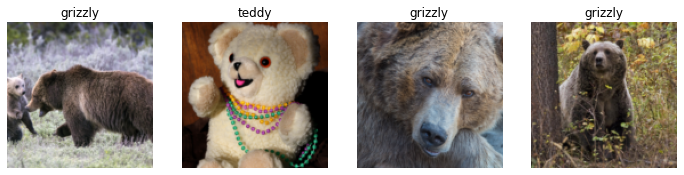

In [202]:
class RawImage(PILImage):
    @classmethod
    def create(cls, item, _kw1='x', _kw2='y'):
        print('\ncls =', cls)
        print('item =', item)
        print('kw1 =', _kw1)
        print('kw2 =', _kw2)
 
        instance = PILImage.create(item)
        print('Instance = ', instance)
        return instance
#       1/0
                 
def RawImageBlock(kw1='XX', kw2='YY'):
    f = partial(RawImage.create, _kw1=kw1, _kw2=kw2) 
    return TransformBlock(type_tfms=f, batch_tfms=IntToFloatTensor)
    
bears = DataBlock(
    blocks=(RawImageBlock(kw1='YEAH', kw2='BABY!'), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
print('bears.dl_type=', bears.dl_type)
print('bears.dls_kwargs=', bears.dls_kwargs)